# PROGETTO CEREALI COCO
# STEP B

In [24]:
import numpy as np
import cv2
import skimage.morphology as skmr
from matplotlib import pyplot as plt
import math
from operator import itemgetter

In [25]:
#constants
T_Q = 5
COLOR_T = 50

### DA RICORDARE SUI KEYPOINTS

### Number of keypoints
print(len(kp_query))

### Location of the keypoint
print(kp_query[0].pt)

### Scale
print(kp_query[0].size)

### Rotation
print(kp_query[0].angle)

### Caricamento modelli

In [26]:
arr_models = ['models/0.jpg', 'models/1.jpg', 'models/11.jpg', 'models/19.jpg', 'models/24.jpg', 'models/25.jpg',
'models/26.jpg']
#idx_models = []
all_models = {}
all_models_gray = {}

def obt_models(img_models):
    for img in img_models:
        idx_models = int(img.split('/')[1].split('.jpg')[0])
        all_models_gray[idx_models] = cv2.imread(img,0) #to detect keypoints
        all_models[idx_models] =cv2.imread(img)
        #plt.imshow(all_models[idx_models])
        #plt.show()

obt_models(arr_models)

### Cariamento scenari

In [27]:
arr_scenes = ['scenes/m1.png', 'scenes/m2.png', 'scenes/m3.png', 'scenes/m4.png', 'scenes/m5.png']
all_scenes = {}
all_scenes_gray = {}

def obt_scenes(arr_scenes):
    index = 0
    for img in arr_scenes: 
        all_scenes_gray[index] = cv2.imread(img,0) #to detect keypoints
        all_scenes[index] = cv2.imread(img)
        #plt.imshow(all_scenes[index])
        #plt.show()
        index+=1
               
obt_scenes(arr_scenes)

### Creazione SIFT function 
sift.detect() function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

In [28]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

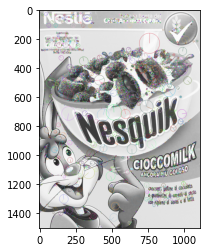

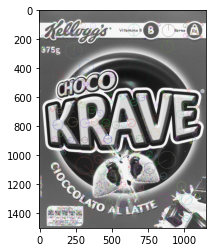

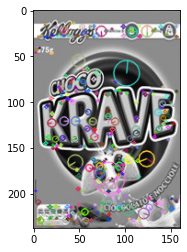

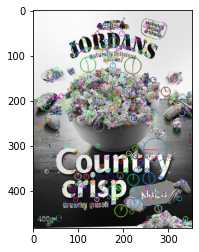

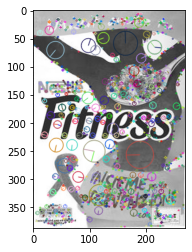

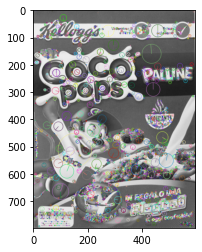

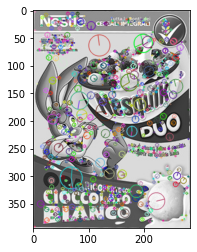

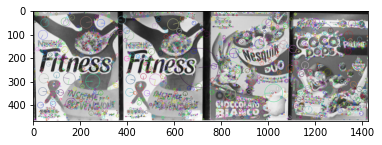

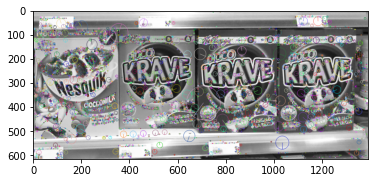

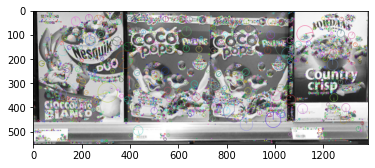

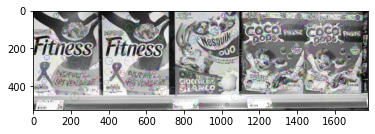

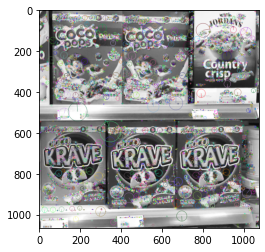

In [29]:
image_dict = {}
models_dict = {}
scenes_dict = {}
description_dict = {}
description_models = []
description_scenes = []


idx_models = ['0', '1', '11', '19','24', '25', '26']

def compute_keypoints(imgs, sift):
    image_dict = {}
    description_dict = {}
    for img in imgs:
        keypoints, descr = sift.detectAndCompute(imgs[img], None)
        description_dict[img] = descr
        image_dict[img] = {'keypoints': keypoints, 'description': descr}
        img_visualization = cv2.drawKeypoints(imgs[img],keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()
        
    return image_dict, description_dict

models_dict, description_models = compute_keypoints(all_models_gray, sift)

scenes_dict, description_scenes = compute_keypoints(all_scenes_gray, sift)

### Find matching

In [30]:
def matching(descr_scene, descr_model):
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)  
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descr_scene,descr_model,k=2)

    return matches

### Trovare i match "buoni"

In [31]:
good_dict = {}
def lowe_ratio_test(match_arr, Treshold):
    good_dict = {}
    for m,n in match_arr:
        if m.distance < Treshold * n.distance: 
            good_dict[m.queryIdx] = m.trainIdx
            
    return good_dict

#### disegno della maschera

If we are iterating over this list of DMatch objects, then each item will have the following attributes:

item.distance: This attribute gives us the distance between the descriptors. A lower distance indicates a better match.

item.trainIdx: This attribute gives us the index of the descriptor in the list of train descriptors (in our case, it’s the list of descriptors in the img2).

item.queryIdx: This attribute gives us the index of the descriptor in the list of query descriptors (in our case, it’s the list of descriptors in the img1).

item.imgIdx: This attribute gives us the index of the train image.

#### function to create the ```hough space```

In [32]:
def get_hough_space(mean_xc, mean_yc, kp_m, kp_s):  
    
    entry_space = {}
    
    translation = ((mean_xc - kp_m.pt[0]), (mean_yc - kp_m.pt[1]))
    
    scale_change = kp_s.size / kp_m.size
    rotation = kp_s.angle - kp_m.angle
    
    x_center = kp_s.pt[0] + scale_change * translation[0]
    y_center = kp_s.pt[1] + scale_change * translation[1]
        
    entry_space['x_center'] = x_center
    entry_space['y_center'] = y_center
    entry_space['scale_change'] = scale_change
    entry_space['rotation'] = rotation
    entry_space['translation'] = translation
    
    return entry_space

In [33]:
def hough_elements(good_dict, kp_s, kp_m, model, mean_xc, mean_yc):
    
    hough_space = {}
    
    for scene_idx, model_idx in good_dict.items():
        hough_space[scene_idx] = get_hough_space(mean_xc, mean_yc, kp_m[model_idx], kp_s[scene_idx])
    
    return hough_space

In [34]:
def calculate_bins(model, scene, hough_space):
    bins_val = {}
    
    scale_change = [space['scale_change'] for space in hough_space.values()]

    counts_scale, bins_scale, _ = plt.hist(scale_change, bins='auto')
    img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
    
    h_model, w_model, l_model = model.shape
    h_scene, w_scene, l_scene = scene.shape

    x_bin_size = img_scale * w_model / 4
    y_bin_size = img_scale * h_model / 4
    
    x_bins = int(np.ceil(w_scene/ x_bin_size)+2)
    y_bins = int(np.ceil(h_scene/ y_bin_size)+2)
    
    return x_bin_size, y_bin_size, x_bins, y_bins

In [35]:
def voting(x_bins, y_bins, good_dict, hough_space):
    votes = {}
    accumulator = np.zeros((x_bins, y_bins))

    for i,v in hough_space.items(): 
        x = int(np.floor(hough_space[i]['x_center'] / x_bin_size))
        y = int(np.floor(hough_space[i]['y_center'] / x_bin_size))
        votes[(x,y)] = votes.get((x,y), [])
        votes[(x,y)].append(i) 
        if x>0 and y>0 and x < x_bins and y<y_bins:
            accumulator[x,y] += 1
            
    #local_maxima of 4-dimensional accumulator
    l_max = skmr.local_maxima(accumulator)
    accumulator[l_max != 1] = 0
    accumulator[accumulator <= 5] =0

    return votes, accumulator

#### funzione per aggiustare gli angoli

In [36]:
def compute_mask(scene, scene_rgb, all_models, s_global_correspondences):
    recognised = {}
    count_model_in_scene = 0 
    thickness = 200
    
    for correspondence in s_global_correspondences:
        
        try:
            count_model_in_scene = 0
            model = all_models[correspondence[1]]
            
            src_pts = np.float32([c[1].pt for c in correspondence[2]]).reshape(-1, 1, 2)
            dst_pts = np.float32([c[0].pt for c in correspondence[2]]).reshape(-1, 1, 2)

            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w,l = model.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            corners = []
            w_scene = scene.shape[1]

            h_scene = scene.shape[0]

            center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))

            x1 = int((dst[0,0,0] + dst[1,0,0]) / 2) if (int((dst[0,0,0] + dst[1,0,0]) / 2) > 0) else 0
            y1 = int((dst[0,0,1] + dst[3,0,1]) / 2) if (int((dst[0,0,1] + dst[3,0,1]) / 2) > 0) else 0
            x2 = int((dst[2,0,0] + dst[3,0,0]) / 2) if (int((dst[2,0,0] + dst[3,0,0]) / 2) < w_scene) else w_scene
            y2 = int((dst[1,0,1] + dst[2,0,1]) / 2) if (int((dst[1,0,1] + dst[2,0,1]) / 2) < h_scene) else h_scene

            corners.append(x1)
            corners.append(y1)
            corners.append(x2)
            corners.append(y2)

            model_mean_color = model.mean(axis=0).mean(axis=0)
            scene_crop = scene[y1:y2, x1:x2]
            scene_mean_color = scene_crop.mean(axis=0).mean(axis=0) 

            #FORMULA COLOR DIFFERENCE - Compute the Euclidean distance with pixels of two images 
            #https://answers.opencv.org/question/127885/how-can-i-best-compare-two-bgr-colors-to-determine-how-similardifferent-they-are/
            val = 0
            for i in abs(model_mean_color - scene_mean_color): 
                val = val+(i**2)
            model_scene_color_diff = np.sqrt(val)

            control_passed = True
            if model_scene_color_diff < COLOR_T : 
                for k, v in recognised.items():
                    for corners in v:
                        r_center = tuple((corners[0, 0, i] + corners[1, 0, i] + corners[2, 0, i] + corners[3, 0, i]) / 4 for i in (0, 1))
                        if (center[0] > min(corners[0, 0, 0], corners[1, 0, 0]) and center[0] < max(corners[2, 0, 0], corners[3, 0, 0])\
                            and center[1] > min(corners[0, 0, 1], corners[3, 0, 1]) and center[1] < max(corners[1, 0, 1], corners[2, 0, 1]))\
                            or (r_center[0] > x1 and r_center[0] < x2 and r_center[1] > y1 and r_center[1] < y2):
                            control_passed = False
                            break
                            
                if control_passed:
                    recognised[correspondence[1]] = recognised.get(correspondence[1], [])  
                    recognised[correspondence[1]].append(dst) 
                    count_model_in_scene += 1
                    draw_scene_rgb = cv2.polylines(scene_rgb, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA) 
                    
                mask_w = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)

                mask_h = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
                
                #print information of the ceral boxes in the scene
                if(count_model_in_scene > 0):
                    center_round = tuple([round(x) if isinstance(x, float) else x for x in center])
                    print('Product {} - {} instance/s found'.format(correspondence[1], count_model_in_scene))
                    print(' '*3,'Position {}, width: {} px, height: {} px'.format(center_round, mask_w, mask_h))
                    
        except: pass 
        
    #plotting scene    
    plt.imshow(draw_scene_rgb), plt.show();
    
    return recognised

#### funzione


Product 24 - 1 instance/s found
    Position (184, 213), width: 352 px, height: 501 px
Product 24 - 1 instance/s found
    Position (550, 219), width: 335 px, height: 489 px
Product 26 - 1 instance/s found
    Position (921, 219), width: 333 px, height: 486 px
Product 25 - 1 instance/s found
    Position (1261, 232), width: 312 px, height: 441 px


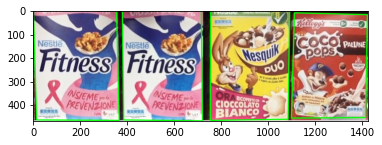

Product 0 - 1 instance/s found
    Position (179, 301), width: 343 px, height: 449 px
Product 1 - 1 instance/s found
    Position (1180, 255), width: 302 px, height: 407 px
Product 1 - 1 instance/s found
    Position (848, 258), width: 312 px, height: 410 px
Product 11 - 1 instance/s found
    Position (511, 252), width: 308 px, height: 401 px


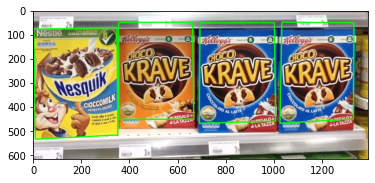

Product 26 - 1 instance/s found
    Position (195, 206), width: 353 px, height: 505 px
Product 25 - 1 instance/s found
    Position (557, 221), width: 334 px, height: 454 px
Product 26 - 1 instance/s found
    Position (921, 219), width: 333 px, height: 486 px
Product 19 - 1 instance/s found
    Position (1233, 190), width: 295 px, height: 383 px


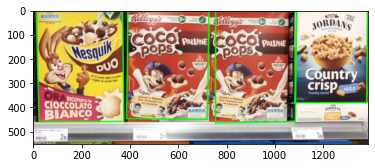

Product 24 - 1 instance/s found
    Position (184, 213), width: 352 px, height: 501 px
Product 24 - 1 instance/s found
    Position (550, 219), width: 335 px, height: 489 px
Product 26 - 1 instance/s found
    Position (921, 219), width: 333 px, height: 486 px
Product 25 - 1 instance/s found
    Position (1261, 232), width: 312 px, height: 441 px
Product 25 - 1 instance/s found
    Position (1588, 214), width: 308 px, height: 436 px


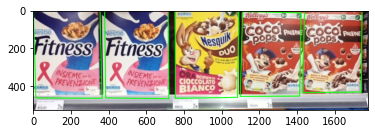

Product 26 - 1 instance/s found
    Position (195, 206), width: 353 px, height: 505 px
Product 25 - 1 instance/s found
    Position (557, 221), width: 334 px, height: 454 px
Product 19 - 1 instance/s found
    Position (909, 190), width: 295 px, height: 384 px
Product 1 - 1 instance/s found
    Position (500, 721), width: 313 px, height: 410 px
Product 1 - 1 instance/s found
    Position (1180, 255), width: 302 px, height: 407 px
Product 1 - 1 instance/s found
    Position (832, 718), width: 302 px, height: 408 px
Product 11 - 1 instance/s found
    Position (163, 713), width: 307 px, height: 402 px


/var/folders/h6/jryybjr150vcmwtlx7_tdqpw0000gn/T/ipykernel_1390/247289865.py:43: RuntimeWarning: Mean of empty slice.
  scene_mean_color = scene_crop.mean(axis=0).mean(axis=0)


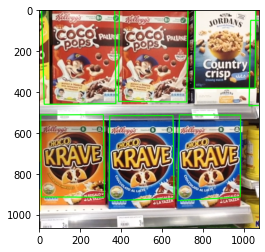

In [37]:
# 1. for in cui cicliamo nelle descrizioni dei scenari e poi nelle desc dei modelli
# 2. per ogni ciclo dobbiamo richiamafe la funzione di good e passargli quel determinato scenario e quel det modello
# 3. fare un check se ci sono abbiastanza good matches e richiamre la funzione che disegna la maschera
index_s = 0
global_correspondences = []

for s_descr in description_scenes:
    kp_s = scenes_dict[index_s]['keypoints']
    
    scene = all_scenes[index_s]
    recognised = {}
    scene_descr = description_scenes[s_descr]
    
    for m_descr in description_models:

        kp_m = models_dict[m_descr]['keypoints']

        model_descr = description_models[m_descr]
        model = all_models[m_descr]
        
        arr_match = matching(scene_descr, model_descr)

        good_dict = lowe_ratio_test(arr_match, 0.55)

        #barycenter of model keypoint
        mean_xc = np.mean(list(kp_m[p].pt[0] for _, p in good_dict.items()))
        mean_yc = np.mean(list(kp_m[p].pt[1] for _, p in good_dict.items()))
        
        hough_space = hough_elements(good_dict, kp_s, kp_m, model, mean_xc, mean_yc)
        
        x_bin_size, y_bin_size, x_bins, y_bins = calculate_bins(model, scene, hough_space)
        
        votes, accumulator = voting(x_bins, y_bins, good_dict, hough_space)
    
        for i in list(np.argwhere(accumulator >= T_Q)): #coordinates of the matrix accumulator
            kepypoint_idx = votes[tuple(i)]
            correspondences = [(kp_s[k], kp_m[good_dict[k]]) for k in kepypoint_idx]
            global_correspondences.append([accumulator[tuple(i)], m_descr, correspondences])
            
    s_global_correspondences = sorted(global_correspondences, key=itemgetter(0), reverse=True)

    scene_img = 'scenes/m' + str(index_s + 1) + '.png'
    r_scene_rgb = cv2.imread(scene_img)
    scene_rgb = cv2.cvtColor(r_scene_rgb, cv2.COLOR_BGR2RGB)
    
    recognised = compute_mask(scene, scene_rgb, all_models, s_global_correspondences)

    index_s += 1